In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
os.chdir("..")
sys.path.append("src")
sys.path.append("data")
os.makedirs('outputs', exist_ok=True)

In [22]:
from data_pipeline import (
    load_dataset,
    preprocess_dataframe,
    vectorize_text,
    split_data,
    evaluate_model
)
from evaluation import (
    evaluate_classification,
    evaluate_roc_auc,
    save_classification_reports
)

In [5]:
# input_file = 'data/climate_stance_data.csv'
# output_file = 'data/climate_stance_data_sample.csv'

# sample_size = 50000 

# # Read a random sample of rows without loading whole file (if it fits memory)
# df = pd.read_csv(input_file, low_memory=False)
# df_clean = df.dropna()
# sample_df = df_clean.sample(n=sample_size, random_state=42)

# sample_df.to_csv(output_file, index=False)

# print(f"Sampled {sample_size} rows saved to {output_file}")

In [6]:
df = load_dataset("data/climate_stance_data_sample.csv")  # Update path as needed
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2019-05-17 23:23:42+00:00,1129527947356807168,-118.755997,36.701463,Politics,-0.420971,believer,female,-1.840842,aggressive
1,2018-12-05 20:45:43+00:00,1070418966567378944,37.617494,55.750446,Donald Trump versus Science,-0.151985,believer,male,-4.707745,not aggressive
2,2019-01-01 07:22:51+00:00,1080001389949042688,-74.006015,40.712728,Donald Trump versus Science,-0.386309,neutral,male,1.438618,not aggressive
3,2018-01-06 09:48:11+00:00,949578332747657216,-0.075530,53.565390,Weather Extremes,0.616958,neutral,male,-0.297181,not aggressive
4,2016-01-07 16:47:57+00:00,685140827002109952,-116.200886,43.616616,Undefined / One Word Hashtags,0.423028,believer,male,3.759840,aggressive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   created_at       50000 non-null  object 
 1   id               50000 non-null  int64  
 2   lng              50000 non-null  float64
 3   lat              50000 non-null  float64
 4   topic            50000 non-null  object 
 5   sentiment        50000 non-null  float64
 6   stance           50000 non-null  object 
 7   gender           50000 non-null  object 
 8   temperature_avg  50000 non-null  float64
 9   aggressiveness   50000 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


In [8]:
X = df.drop(columns=["stance", "created_at", "id"])
y = df["stance"]

In [9]:
numeric_features = ["sentiment", "temperature_avg", "lng", "lat"]
categorical_features = ["topic", "gender", "aggressiveness"]

In [10]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [11]:
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

In [12]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42),
}

In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
# cv_scores = cross_val_score(pipe, X_train, y_train_encoded, cv=5, scoring="accuracy")
# print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [15]:
results = {}

for name, clf in models.items():
    print(f"\nTraining and evaluating {name}...")
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
    
    # Cross-validation accuracy
    cv_scores = cross_val_score(pipe, X_train, y_train_encoded, cv=5, scoring="accuracy")
    print(f"{name} CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Train on full train set and predict test set
    pipe.fit(X_train, y_train_encoded)
    y_pred_encoded = pipe.predict(X_test)
    y_pred = le.inverse_transform(y_pred_encoded)
    
    print(f"{name} classification report:\n", classification_report(y_test, y_pred))
    
    # Store for confusion matrix plot
    results[name] = (y_test, y_pred)


Training and evaluating Decision Tree...
Decision Tree CV Accuracy: 0.6556 ± 0.0053
Decision Tree classification report:
               precision    recall  f1-score   support

    believer       0.80      0.79      0.79      7471
      denier       0.21      0.21      0.21       732
     neutral       0.30      0.31      0.31      1797

    accuracy                           0.66     10000
   macro avg       0.43      0.44      0.44     10000
weighted avg       0.66      0.66      0.66     10000


Training and evaluating Random Forest...
Random Forest CV Accuracy: 0.7498 ± 0.0033
Random Forest classification report:
               precision    recall  f1-score   support

    believer       0.78      0.95      0.86      7471
      denier       0.34      0.07      0.12       732
     neutral       0.49      0.21      0.29      1797

    accuracy                           0.75     10000
   macro avg       0.54      0.41      0.42     10000
weighted avg       0.70      0.75      0.70    

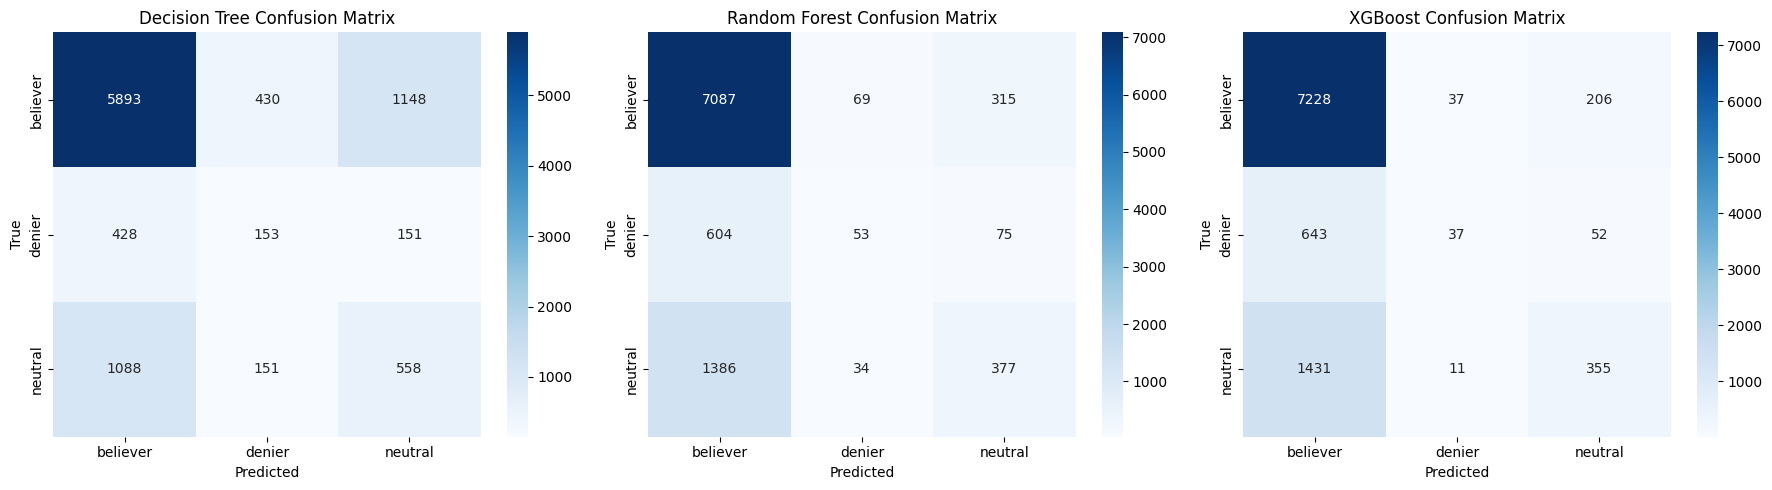

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = sorted(y.unique())  # Ensure these match y_true/y_pred types

for ax, (name, (y_true, y_pred)) in zip(axes, results.items()):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()

# Save only once, after all subplots are created
fig.savefig(os.path.join('outputs', 'confusion_matrix.png'))

plt.show()

In [24]:
metrics = evaluate_classification(y_test, y_pred)
print(metrics)

auc = evaluate_roc_auc(y_test, pipe.predict_proba(X_test))
print(f"ROC AUC: {auc:.4f}")

save_classification_reports(y_test, y_pred, labels=["believer", "denier", "neutral"])


{'accuracy': 0.762, 'precision': 0.597150133469654, 'recall': 0.40519071882370267, 'f1_score': 0.41568080309151156}
ROC AUC: 0.7335
              precision    recall  f1-score   support

    believer       0.78      0.97      0.86      7471
      denier       0.44      0.05      0.09       732
     neutral       0.58      0.20      0.29      1797

    accuracy                           0.76     10000
   macro avg       0.60      0.41      0.42     10000
weighted avg       0.72      0.76      0.70     10000

